**9장 – 비지도 학습**

_이 노트북에는 9장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/09_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 9.0 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 사이킷런 ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

이전 챕터에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

그리고 아직 존재하지 않는 경우 `images/unsupervised_learning` 폴더를 만들고 이 노트북을 통해 책의 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 9.1 군집

**소개 – 분류 _vs_ 군집**

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 44867 (\N{HANGUL SYLLABLE GGOC}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51086 (\N{HANGUL SYLLABLE IP}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 44867 (\N{HANGUL SYLLABLE GGOC}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/

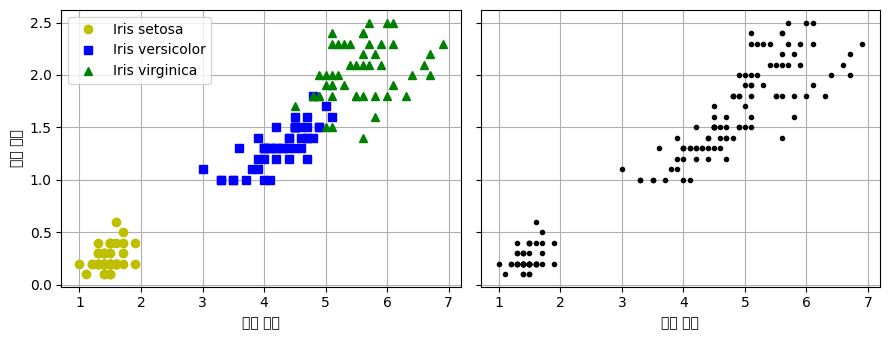

In [5]:
# 추가 코드 - 이 셀은 그림 9-1을 생성하고 저장합니다.

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("꽃잎 길이")
plt.ylabel("꽃잎 너비")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("꽃잎 길이")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

save_fig("classification_vs_clustering_plot")
plt.show()

**참고**: 다음 셀은 가우스 혼합 모델(이 장의 뒷부분에서 설명)이 꽃잎 길이와 너비, 꽃받침 길이와 너비의 네 가지 특징을 모두 사용하여 실제로 이러한 클러스터를 어떻게 잘 구분할 수 있는지 보여 줍니다. 이 코드는 각 클러스터를 클래스에 매핑합니다. 이 코드는 매핑을 하드 코딩하는 대신 `scipy.stats.mode()` 함수를 사용하여 각 클러스터에 대해 가장 일반적인 클래스를 선택합니다:

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44867 (\N{HANGUL SYLLABLE GGOC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51086 (\N{HANGUL SYLLABLE IP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  fig.canvas.print_figur

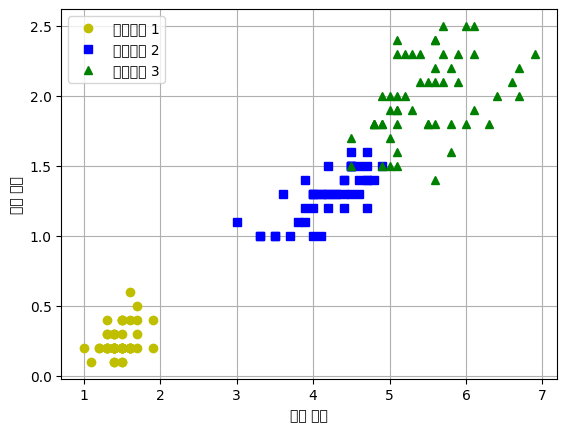

In [6]:
# 추가 코드

import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    # SciPy 1.11.0에서 `keepdims` 기본값이 False로 바뀐다는 경고를 피하기 위해 명시적으로 지정함
    mode, _ = stats.mode(y_pred[y==class_id], keepdims=False)
    mapping[mode] = int(class_id)

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="클러스터 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="클러스터 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="클러스터 3")
plt.xlabel("꽃잎 길이")
plt.ylabel("꽃잎 너비")
plt.legend(loc="upper left")
plt.grid()
plt.show()

올바른 클러스터에 할당된 붓꽃의 비율은 얼마입니까?

In [7]:
(y_pred==y).sum() / len(y_pred)

np.float64(0.9666666666666667)

## 9.1.1 K-평균

**fit 그리고 predict**

사이킷런 1.4 버전에서 `KMeans`의 `n_init` 매개변수 기본값이 10에서 `"auto"`로 바뀔 예정입니다. 이 노트북에서는 명시적으로 10으로 지정하여 사용합니다.

블롭(blob)이 있는 데이터 세트에 대해 K-평균 클러스터러를 훈련해 보겠습니다. 이 클러스터러는 각 블롭의 중심을 찾아 가장 가까운 블롭에 각 인스턴스를 할당하려고 시도합니다:

In [13]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 추가 코드 - make_blobs()의 정확한 인수는 중요하지 않습니다.
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

# ...
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

이제 플로팅해 보겠습니다:

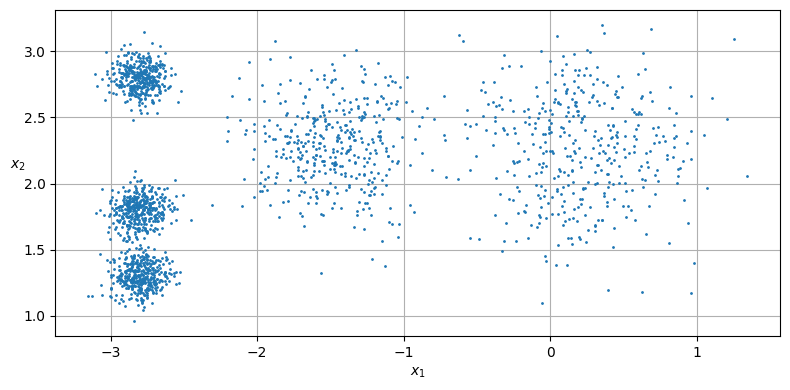

In [14]:
# 추가 코드 - 이 셀은 그림 9-2를 생성하고 저장합니다.

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

각 샘플은 5개의 클러스터 중 하나에 할당되었습니다:

In [15]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

In [16]:
y_pred is kmeans.labels_

True

그리고 다음과 같은 5개의 _센트로이드_(즉, 클러스터 중심)을 추정했습니다:

In [17]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

`KMeans`의 객체는 훈련된 샘플의 레이블을 보존한다는 점에 유의하세요. 다소 혼란스러울 수 있지만, 이 맥락에서 샘플의 _레이블_ 은 샘플이 할당된 클러스터의 인덱스입니다(타깃이 아니라 예측입니다):

In [18]:
kmeans.labels_

array([2, 2, 4, ..., 1, 4, 2], dtype=int32)

물론 새로운 샘플의 레이블을 예측할 수 있습니다:

In [19]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

**결정 경계**

모델의 결정 경계를 그려 보겠습니다. 이렇게 하면 _보로노이 다이어그램_이 생성됩니다:

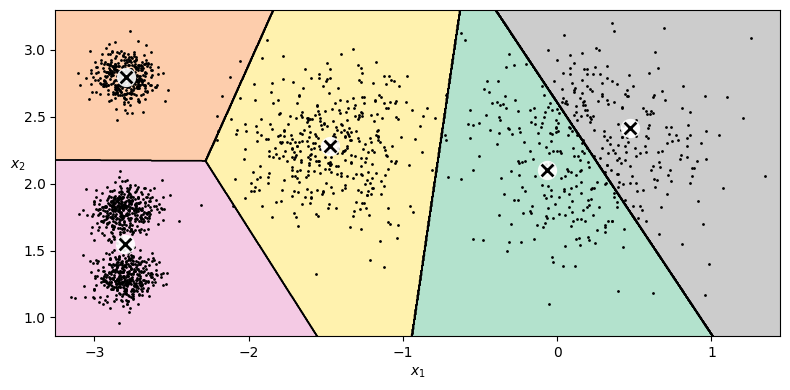

In [20]:
# 추가 코드 - 이 셀은 그림 9-3을 생성하고 저장합니다.

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

나쁘지 않습니다! 가장자리 근처의 샘플 중 일부는 아마도 잘못된 클러스터에 할당되었을 수 있지만 전반적으로 꽤 괜찮아 보입니다.

**하드 군집 _vs_ 소프트 군집**

_하드 클러스터링_은 각 샘플에 대해 가장 가까운 클러스터를 선택합니다. 이 대신 각 샘플과 5개의 중심까지의 거리를 측정하는 것이 더 나을 수 있습니다. 이것이 바로 `transform()` 메서드가 하는 일입니다:

In [21]:
kmeans.transform(X_new).round(2)

array([[0.12, 2.9 , 2.84, 1.5 , 0.63],
       [3.07, 5.85, 5.82, 4.48, 2.56],
       [3.07, 0.29, 1.46, 1.69, 3.52],
       [2.96, 0.36, 0.97, 1.54, 3.47]])

이것이 실제로 각 샘플과 각 중심 사이의 유클리드 거리임을 확인할 수 있습니다:

In [22]:
# 추가 코드
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[0.12, 2.9 , 2.84, 1.5 , 0.63],
       [3.07, 5.85, 5.82, 4.48, 2.56],
       [3.07, 0.29, 1.46, 1.69, 3.52],
       [2.96, 0.36, 0.97, 1.54, 3.47]])

### K-평균 알고리즘

K-평균 알고리즘은 가장 빠른 클러스터링 알고리즘 중 하나이며 가장 간단한 알고리즘이기도 합니다:
* 먼저 $k$개의 중심을 무작위로 초기화합니다. 예를 들어, 데이터 세트에서 $k$개의 샘플을 무작위로 선택하고 해당 위치에 센트로이드를 할당합니다.
* 수렴할 때까지(즉, 중심이 움직이지 않을 때까지) 반복합니다:
    * 각 인스턴스를 가장 가까운 센트로이드에 할당합니다.
    * 할당된 샘플의 평균이 되도록 센트로이드를 업데이트합니다.

`K-Means` 클래스는 기본적으로 최적화된 초기화 기법을 사용합니다. 원래의 K-Means 알고리즘(교육용으로만 사용)을 사용하려면 `init="random"` 및 `n_init=1`을 설정해야 합니다. 이에 대해서는 이 장의 뒷부분에서 자세히 설명합니다.

K-평균 알고리즘을 1, 2, 3회 반복하여 센트로이드가 어떻게 움직이는지 확인해 보겠습니다:

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWar

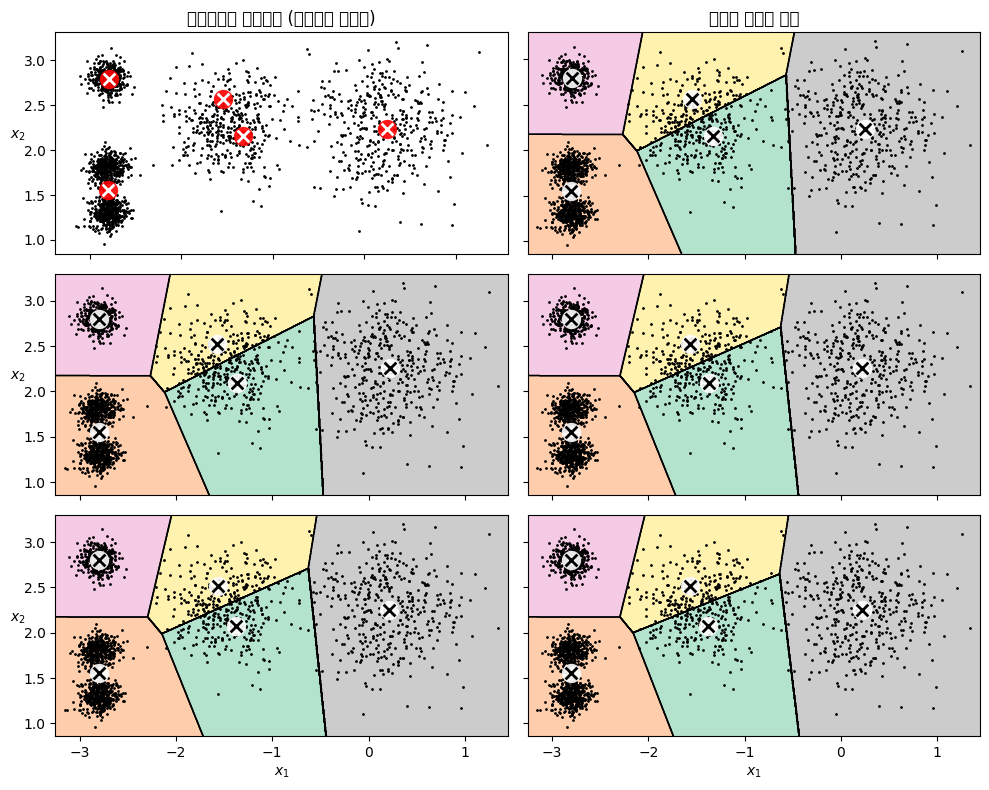

In [23]:
# 추가 코드 - 이 셀은 그림 9-4를 생성하고 저장합니다.

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("센트로이드 업데이트 (랜덤하게 초기화)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("샘플에 레이블 할당")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**K-평균 가변성**

원래 K-평균 알고리즘에서는 센트로이드가 무작위로 초기화되고 알고리즘은 위에서 살펴본 것처럼 단일 반복을 실행하여 센트로이드를 점진적으로 개선하기만 하면 됩니다.

그러나 이 접근 방식의 한 가지 주요 문제점은 아래에서 볼 수 있듯이 K-Means를 여러 번(또는 다른 무작위 시드를 사용하여) 실행하면 매우 다른 솔루션으로 수렴할 수 있다는 점입니다:

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49556 (\N{HANGUL SYLLABLE SOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49496 (\N{HANGUL SYLLABLE SYEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: 

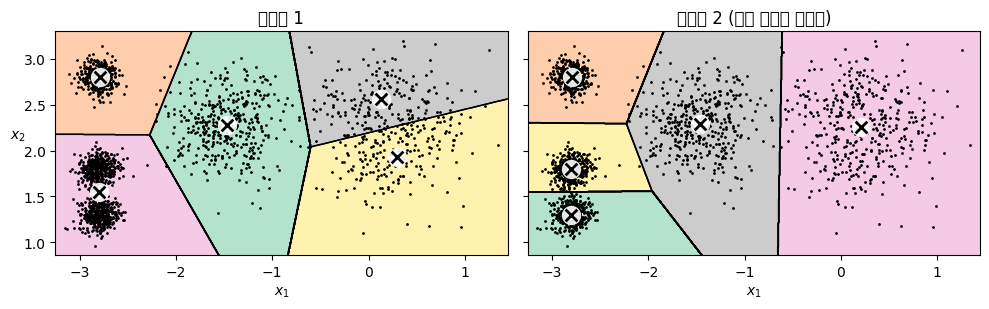

In [24]:
# 추가 코드 - 이 셀은 그림 9-5를 생성하고 저장합니다.

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "솔루션 1",
                          "솔루션 2 (다른 랜덤한 초기화)")

save_fig("kmeans_variability_plot")
plt.show()

In [25]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

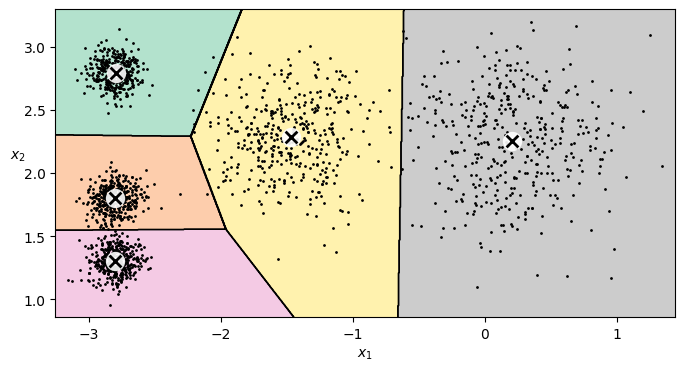

In [26]:
# 추가 코드
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### 이너셔

최적의 모델을 선택하려면 K-평균 모델의 성능을 평가할 수 있는 방법이 필요합니다. 안타깝게도 군집은 비지도 학습이기 때문에 타깃이 없습니다. 하지만 적어도 각 샘플과 그 센트로이드 사이의 거리는 측정할 수 있습니다. 이것이 바로 _관성_ 지표의 기본 개념입니다:

In [27]:
kmeans.inertia_

211.5985372581684

In [28]:
kmeans_rnd_init1.inertia_  # 추가 코드

219.58201503602282

In [29]:
kmeans_rnd_init2.inertia_  # 추가 코드

211.5985372581684

쉽게 확인할 수 있듯이 관성은 각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합입니다:

In [30]:
# 추가 코드
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

np.float64(211.59853725816868)

`score()` 메서드는 음의 이너셔를 반환합니다. 왜 음수일까요? 예측기의 `score()` 메서드는 항상 "_크면 클수록 좋다_"는 규칙을 준수해야 하기 때문입니다.

In [31]:
kmeans.score(X)

-211.59853725816836

### 다중 초기화

따라서 가변성 문제를 해결하기 위한 한 가지 접근 방식은 다양한 무작위 초기화를 사용하여 K-평균 알고리즘을 여러 번 실행하고 이너셔를 최소화하는 솔루션을 선택하는 것입니다.

`n_init` 하이퍼파라미터를 설정하면 Scikit-Learn은 원래 알고리즘인 `n_init`을 여러 번 실행하여 이너셔를 최소화하는 솔루션을 선택합니다. 기본적으로 Scikit-Learn은 `n_init=10`으로 설정되어 있습니다.

In [32]:
# 추가 코드
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

다음에 보듯이 최적의 K-평균 솔루션에 해당하는 초기 모델을 얻었습니다(적어도 관성 측면에서, 그리고 $k=5$라고 가정할 때).

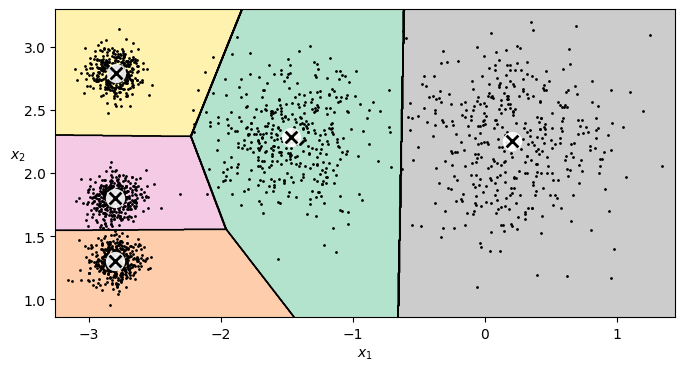

In [33]:
# 추가 코드
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [34]:
kmeans_rnd_10_inits.inertia_

211.5985372581684

### 센트로이드 초기화 방법

센트로이드를 완전히 무작위로 초기화하는 대신 데이비드 아서와 세르게이 바실비츠키가 [2006년 논문](https://goo.gl/eNUPw6)에서 제안한 다음 알고리즘을 사용하여 초기화하는 것이 바람직합니다:
* 데이터셋에서 무작위로 균일하게 하나의 센트로이드를 $c_1$을 선택합니다.
* $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$으로 선택합니다. $D(\mathbf{x}_i)$ 는 인스턴스 $\mathbf{x}_i$ 와 이미 선택된 가장 가까운 센트로이드 사이의 거리입니다. 이 확률 분포는 이미 선택된 센트로이드로부터 멀리 떨어진 샘플이 센트로이드로 선택될 확률을 훨씬 더 높입니다.
* 모든 $k$개 센트로이드가 선택될 때까지 이전 단계를 반복합니다.

나머지 K-평균++ 알고리즘은 일반 K-평균과 같습니다. 이 초기화를 사용하면 K-평균 알고리즘이 최적이 아닌 솔루션으로 수렴할 가능성이 훨씬 낮아지므로 `n_init`을 상당히 줄일 수 있습니다. 대부분의 경우 초기화 프로세스의 추가 복잡성을 크게 보완할 수 있습니다.

초기화를 K-Means++로 설정하려면 `init="k-means++"`를 설정하기만 하면 됩니다(실제로는 이것이 기본값입니다):

### 가속화된 K-평균

K-Means 알고리즘은 불필요한 거리 계산을 많이 피함으로써 때때로 속도를 높일 수 있습니다: 이는 삼각형 부등식(세 점 A, B, C가 주어졌을 때 거리 AC는 항상 AC ≤ AB + BC)을 활용하고 인스턴스와 센트로이드 사이의 거리에 대한 하한과 상한을 추적함으로써 달성됩니다(자세한 내용은 Charles Elkan의 [2003 논문](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf)을 참조하세요).

엘칸 방식의 K-평균을 사용하려면 `algorithm="elkan"`을 사용합니다. 일반 K-평균의 경우 `algorithm="full"`을 사용합니다. 기본값은 `"auto"`로, Scikit-Learn 1.1부터 `full` 알고리즘을 사용합니다(그 이전에는 엘칸 알고리즘을 사용함).

### 미니 배치 K-평균

사이킷런 1.4 버전에서 `MiniBatchKMeans`의 `n_init` 매개변수 기본값이 3에서 `"auto"`로 바뀔 예정입니다. 이 노트북에서는 명시적으로 3으로 지정하여 사용합니다.

Scikit-Learn은 미니 배치를 지원하는 K-Means 알고리즘의 변형도 제공합니다([이 논문](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) 참조):

In [39]:
from sklearn.cluster import MiniBatchKMeans

miniBatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state= 42)
miniBatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [40]:
miniBatch_kmeans.inertia_

211.6594510571261

**`memmap`과 함께 `MiniBatchKMeans` 사용하기** (책에 없음)

데이터셋이 메모리에 맞지 않는 경우 가장 간단한 옵션은 이전 장에서 점진적 PCA에서 했던 것처럼 `memmap` 클래스를 사용하는 것입니다. 먼저 MNIST를 로드해 보겠습니다:

In [41]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")

데이터셋을 분할해 보겠습니다:

In [42]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

다음으로 훈련 세트를 `memmap`에 저장해 보겠습니다:

In [43]:
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                     shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush()

In [44]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                   n_init=3, random_state=42)
minibatch_kmeans.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, n_init=3, random_state=42)

미니 배치 K-평균과 일반 K-평균 간의 이너셔 비율과 훈련 시간 비율을 플롯해 보겠습니다:

100/100

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49492 (\N{HANGUL SYLLABLE SYEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: Us

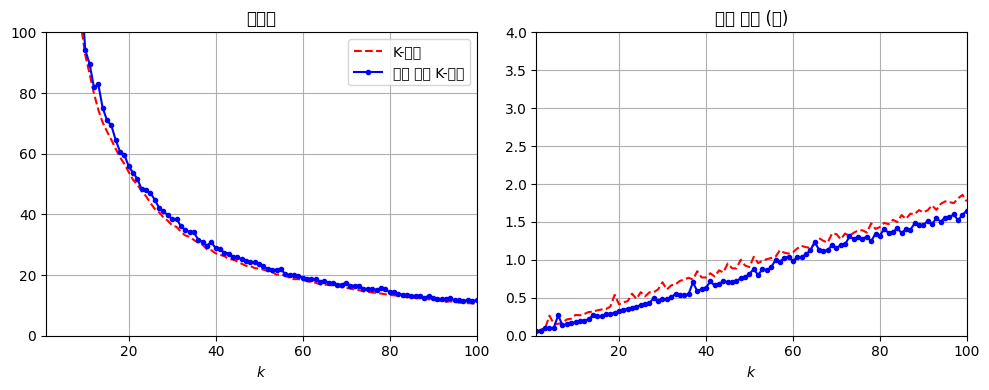

In [45]:
# 추가 코드 - 이 셀은 그림 9-6을 생성하고 저장합니다.

from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    # 사이킷런 1.3에서 'full'이 deprecated 된다는 경고를 피하기 위해 'lloyd'로 지정함
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-평균")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="미니 배치 K-평균")
plt.xlabel("$k$")
plt.title("이너셔")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-평균")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="미니 배치 K-평균")
plt.xlabel("$k$")
plt.title("훈련 시간 (초)")
plt.axis([1, max_k, 0, 4])
plt.grid()

save_fig("minibatch_kmeans_vs_kmeans_plot")
plt.show()

### 최적의 클러스터 수 찾기

클러스터 수가 5보다 작거나 큰 값으로 설정된 경우 어떻게 되나요?

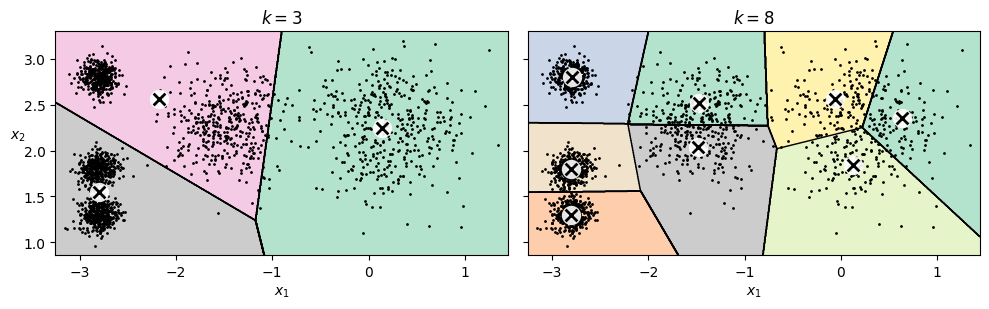

In [46]:
# 추가 코드 - 이 셀은 그림 9-7을 생성하고 저장합니다.

kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

이 두 모델은 보기가 좋지 않습니다. 이너셔는 어떨까요?

In [47]:
kmeans_k3.inertia_

653.216719002155

In [48]:
kmeans_k8.inertia_

119.22484592677111

아니요, $k$를 증가시키면 이너셔가 계속 낮아지기 때문에 단순히 이너셔를 최소화하는 $k$의 값을 취할 수는 없습니다. 실제로 클러스터가 많을수록 각 인스턴스가 가장 가까운 중심점에 가까워지므로 이너셔가 낮아집니다. 그러나 이너셔를 $k$의 함수로 플롯하고 결과 곡선을 분석할 수 있습니다:

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49492 (\N{HANGUL SYLLABLE SYEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 50648 (\N{HANGUL SYLLABLE EL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  plt.savefig(path, format=f

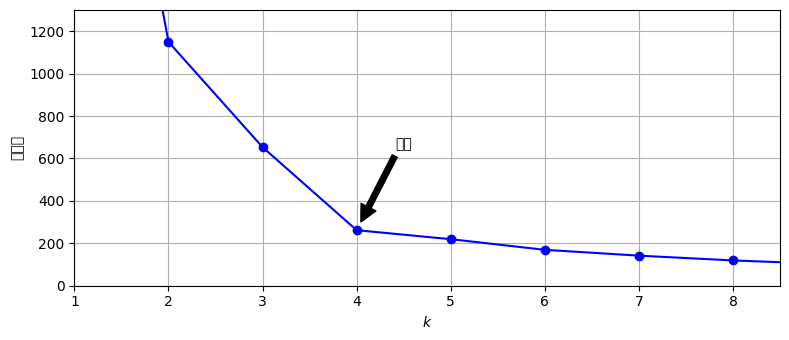

In [49]:
# 추가 코드 - 이 셀은 그림 9-8을 생성하고 저장합니다.

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("이너셔")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "엘보", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

보시다시피 $k=4$에 엘보가 있는데, 이는 클러스터 수가 이보다 적으면 좋지 않고 클러스터 수가 많으면 큰 도움이 되지 않으며 클러스터 수를 절반으로 줄일 수 있음을 의미합니다. 따라서 $k=4$는 꽤 좋은 선택입니다. 물론 이 예제에서는 왼쪽 하단의 두 개의 블롭이 하나의 클러스터로 간주되기 때문에 완벽하지는 않지만, 그럼에도 불구하고 꽤 좋은 군집 결과입니다.

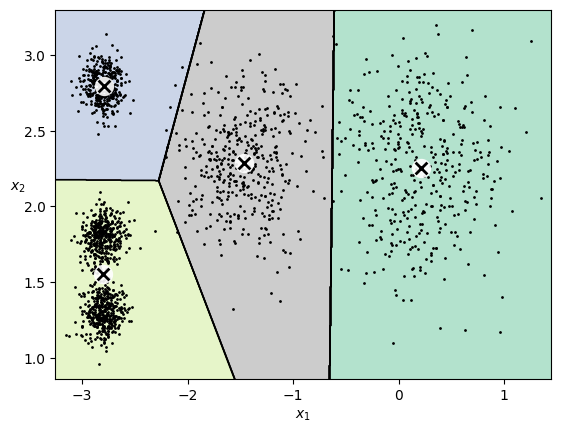

In [50]:
# 추가 코드
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

또 다른 접근 방식은 모든 샘플에 대한 평균 _실루엣 계수_인 _실루엣 점수_를 살펴보는 것입니다. 샘플의 실루엣 계수는 (_b_ - _a_) / max(_a_, _b_) 와 같으며, 여기서 _a_ 는 동일한 클러스터에 있는 다른 샘플과의 평균 거리(_평균 클러스터 내 거리_)이고, _b_ 는 _평균 가장 가까운 클러스터 거리_, 즉 다음으로 가까운 클러스터(샘플의 자체 클러스터를 제외하고 _b_ 를 최소화하는 클러스터로 정의)의 샘플과의 평균 거리입니다. 실루엣 계수는 -1에서 +1 사이에서 달라질 수 있습니다. 계수가 +1에 가까우면 샘플이 자체 클러스터 내부에 있고 다른 클러스터와 멀리 떨어져 있음을 의미하고, 계수가 0에 가까우면 클러스터 경계에 가깝다는 의미이며, 마지막으로 -1에 가까우면 샘플이 잘못된 클러스터에 할당되었을 수 있음을 의미합니다.

실루엣 점수를 $k$의 함수로 플롯해 보겠습니다:

In [51]:
from sklearn.metrics import silhouette_score

In [52]:
silhouette_score(X, kmeans.labels_)

np.float64(0.655517642572828)

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  plt.savefig(path, format

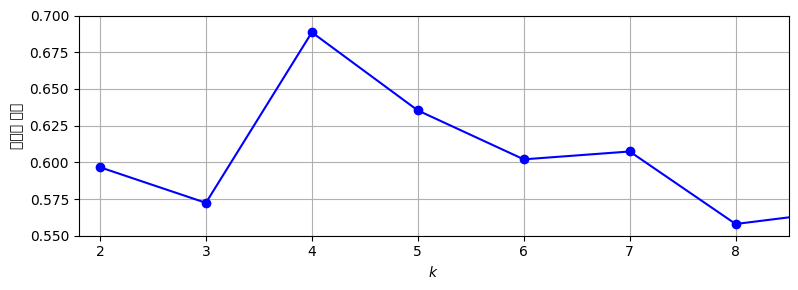

In [53]:
# 추가 코드 - 이 셀은 그림 9-9를 생성하고 저장합니다.

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("실루엣 점수")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

보시다시피, 이 시각화는 이전 시각화보다 훨씬 더 풍부합니다. 특히 $k=4$가 매우 좋은 선택이라는 것을 확인하지만, $k=5$도 상당히 좋다는 사실도 강조합니다.

모든 샘플의 실루엣 계수를 할당된 클러스터와 계수 값에 따라 정렬하여 플로팅하면 훨씬 더 많은 정보를 시각화할 수 있습니다. 이를 _실루엣 다이어그램_이라고 합니다:

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: User

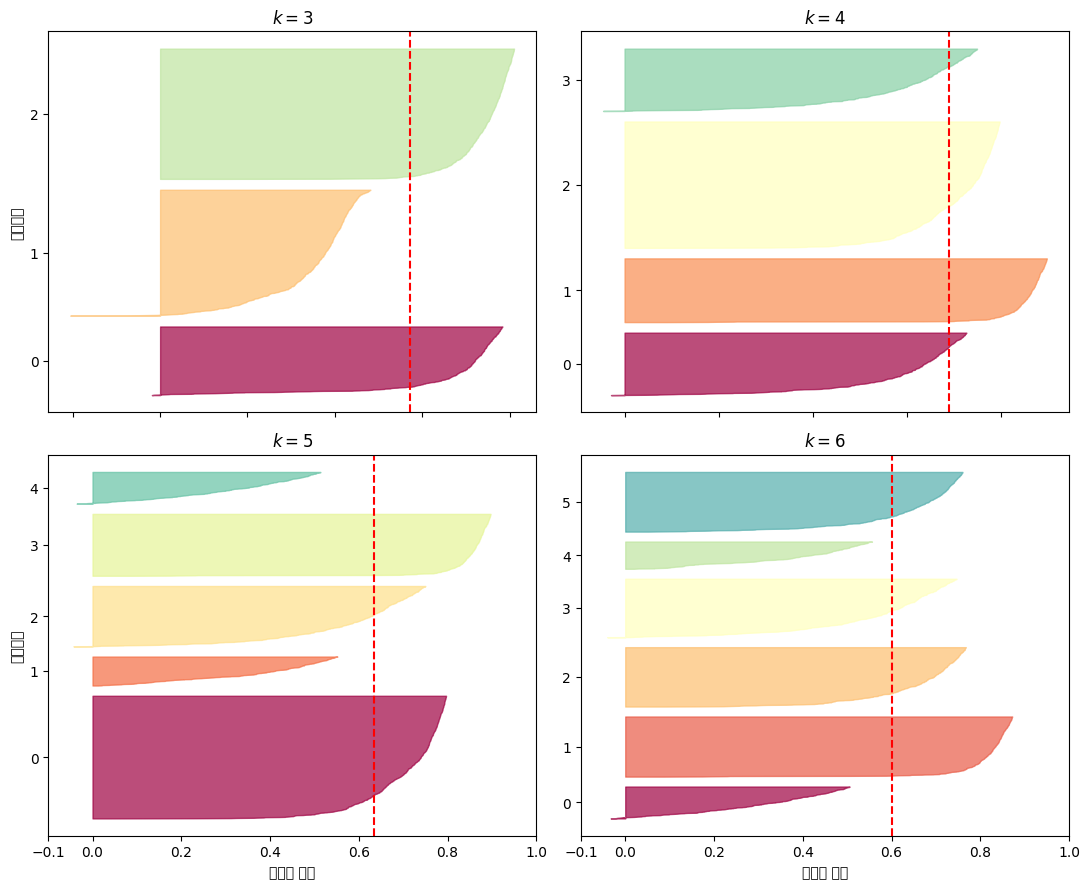

In [54]:
# 추가 코드 - 이 셀은 그림 9-10을 생성하고 저장합니다.

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("클러스터")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("실루엣 계수")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

보시다시피 모든 클러스터의 크기가 거의 같고 평균 실루엣 점수를 나타내는 점선을 모두 교차하기 때문에 $k=5$가 가장 좋은 옵션으로 보입니다.

## 9.1.2 K-평균의 한계

길쭉한 블롭과 다양한 밀도를 가진 더 어려운 데이터셋을 생성하고, K-평균이 이 데이터셋을 올바르게 클러스터링하는 데 어려움을 겪는다는 것을 보여드리겠습니다:

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49492 (\N{HANGUL SYLLABLE SYEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 49492 (\N{HANGUL SYLLABLE SYEO}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/p

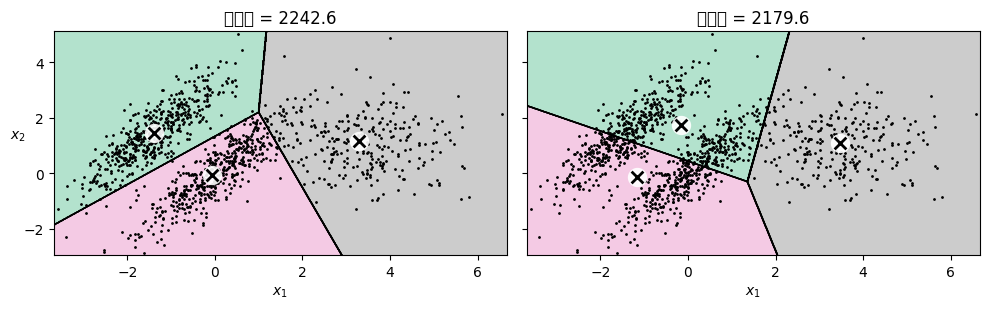

In [55]:
# 추가 코드 - 이 셀은 그림 9-11을 생성하고 저장합니다.

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"이너셔 = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"이너셔 = {kmeans_bad.inertia_:.1f}")

save_fig("bad_kmeans_plot")
plt.show()

## 9.1.3 군집을 사용한 이미지 분할

무당벌레 이미지를 다운로드합니다:

In [56]:
# 추가 코드 - 무당벌레 이미지 다운로드

import urllib.request

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [57]:
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

In [58]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state= 42 ).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.
  plt.save

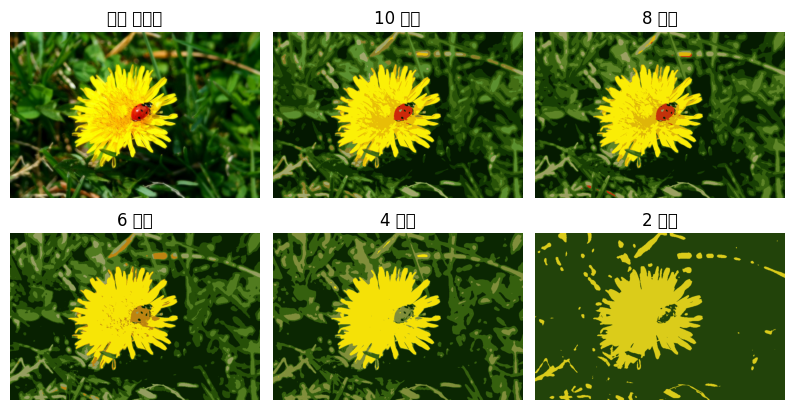

In [59]:
# 추가 코드 - 이 셀은 그림 9-12를 생성하고 저장합니다.

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("원본 이미지")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} 색상")
    plt.axis('off')

save_fig('image_segmentation_plot', tight_layout=False)
plt.show()

## 9.1.4 군집을 사용한 준지도 학습

군집의 또 다른 사용 사례는 레이블이 지정되지 않은 샘플이 많고 레이블이 지정된 샘플이 매우 적은 경우의 준지도 학습입니다.

숫자 0에서 9까지를 나타내는 1,797개의 8×8 흑백 이미지가 포함된 MNIST와 유사한 데이터셋인 간단한 _digits 데이터셋_ 을 살펴봅시다.

In [60]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:],y_digits[1400:]

레이블이 지정된 샘플이 50개만 있을 때 로지스틱 회귀 모델의 성능을 살펴보겠습니다:

In [61]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled],y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [62]:
log_reg.score(X_test, y_test)

0.7581863979848866

In [63]:
# 추가 코드 - 전체 훈련 세트를 사용할 때의 정확도 측정
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

물론 이전보다는 훨씬 적습니다. 어떻게 하면 더 잘할 수 있는지 살펴봅시다. 먼저 훈련 세트를 50개의 클러스터로 모은 다음 각 클러스터에 대해 센트로이드에 가장 가까운 이미지를 찾아보겠습니다. 이 이미지를 대표 이미지라고 부르겠습니다:

In [64]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

이제 이러한 대표 이미지를 플로팅하고 수동으로 레이블을 지정해 보겠습니다:

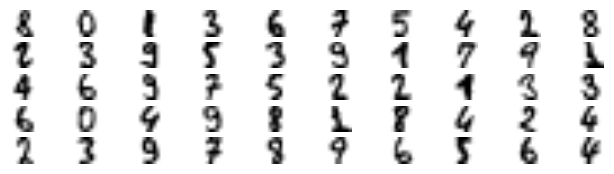

In [65]:
# 추가 코드 - 이 셀은 그림 9-13을 생성하고 저장합니다.

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

In [71]:
y_representative_digits = np.array([
    8,0,1,3,6,7,5,4,2,8,
    2,3,9,5,3,9,1,7,9,1,
    4,6,9,7,5,2,2,1,3,3,
    6,0,4,9,8,1,8,4,2,4,
    2,3,9,7,8,9,6,5,6,4
])

이제 50개의 레이블이 지정된 샘플만 있는 데이터 세트가 있지만, 완전히 무작위 샘플이 아니라 각 샘플이 클러스터의 대표 이미지입니다. 성능이 더 좋아졌는지 살펴봅시다:

In [72]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8312342569269522

와우! 정확도가 74.8%에서 84.9%로 뛰어올랐지만, 아직 50개의 샘플로만 모델을 훈련하고 있습니다. 샘플에 레이블을 지정하는 작업은 비용이 많이 들고 번거로운 경우가 많으며, 특히 전문가가 수동으로 수행해야 하는 경우에는 무작위 샘플보다는 대표적인 샘플에 레이블을 지정하는 것이 좋습니다.

하지만 한 단계 더 나아가 동일한 클러스터의 다른 모든 샘플에 레이블을 전파하면 어떨까요?

In [73]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [74]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

In [75]:
log_reg.score(X_test, y_test)

0.8690176322418136

정확도가 또 한 번 크게 향상되었습니다! 클러스터 중심에서 가장 멀리 떨어진 1%의 샘플을 무시하면 더 나은 결과를 얻을 수 있는지 확인해 보겠습니다. 이렇게 하면 일부 이상치가 제거됩니다:

In [76]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [77]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8614609571788413

와, 또 한 번 정확도가 향상되었습니다! 완전히 레이블이 지정된 훈련 세트로 훈련했을 때 얻은 성능을 약간 능가했습니다!

실제로 전파된 레이블의 정확도는 약 97.6%에 달할 정도로 매우 우수합니다:

In [78]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.9614814814814815)

이제 *능동 학습*을 몇 번 반복할 수 있습니다:
1. 가능하면 각각의 클러스터에서 분류기가 가장 불확실하게 예측하는 샘플에 수동으로 레이블을 지정합니다.
2. 이러한 추가 레이블을 사용하여 새 모델을 학습시킵니다.

## 9.1.5 DBSCAN

In [79]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [80]:
dbscan.labels_[:10]

array([ 0,  1,  2,  3,  2,  0,  0, -1,  3,  4])

In [81]:
dbscan.core_sample_indices_[:10]

array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 11])

In [82]:
dbscan.components_

array([[ 0.17790792,  0.9608892 ],
       [ 0.96573478,  0.02475452],
       [ 0.04064989,  0.29592638],
       ...,
       [ 1.74367433, -0.1479788 ],
       [ 0.8190055 ,  0.55743578],
       [ 0.0337501 ,  0.96894814]])

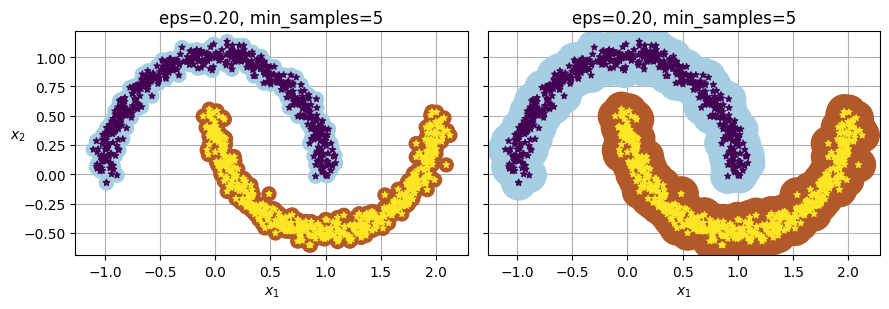

In [85]:
# 추가 코드 - 이 셀은 그림 9-14를 생성하고 저장합니다.

def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

In [86]:
dbscan = dbscan2  # 추가 코드 - 책에는 eps=0.2를 사용한다고 나와 있습니다.

In [87]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_,dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [88]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([0, 1, 0, 1])

In [89]:
knn.predict_proba(X_new)

array([[0.8, 0.2],
       [0. , 1. ],
       [0.8, 0.2],
       [0. , 1. ]])

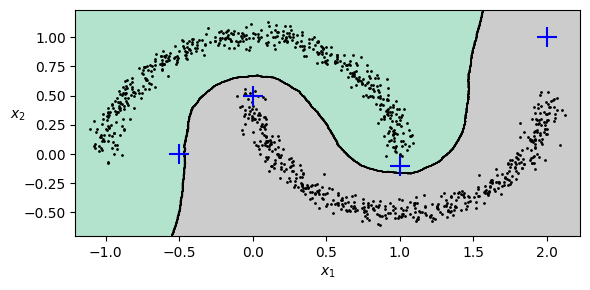

In [90]:
# 추가 코드 - 이 셀은 그림 9-15를 생성하고 저장합니다.

plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [92]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  1,  0, -1])

## 9.1.6 기타 군집 알고리즘

이 섹션의 코드는 책에 포함되어 있지 않은 보너스 자료입니다.

### 스펙트럼 군집

In [94]:
from sklearn.cluster import SpectralClustering

In [95]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [96]:
sc1.affinity_matrix_.round(2)

array([[1.  , 0.  , 0.  , ..., 0.  , 0.12, 0.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [0.12, 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

In [97]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [98]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True,
                             show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"RBF gamma={sc.gamma}")

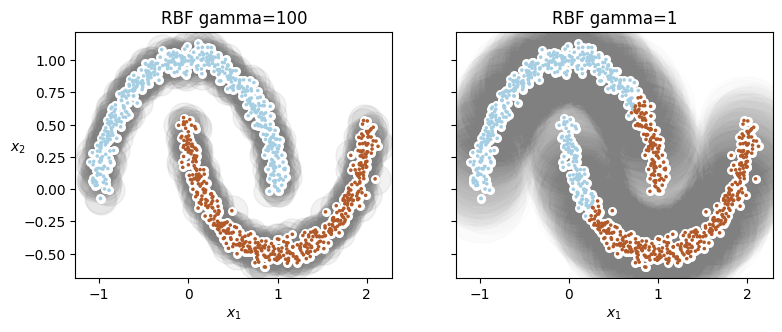

In [99]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

### 병합 군집

In [100]:
from sklearn.cluster import AgglomerativeClustering

In [101]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [102]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [103]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [104]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# 9.2 가우스 혼합

(K-평균이 문제를 겪었던) 앞서와 동일한 세 개의 타원형 클러스터를 가진 데이터셋을 생성해 보겠습니다:

In [105]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

이 데이터셋에서 가우스 혼합 모델을 훈련해 보겠습니다:

In [106]:
from sklearn.mixture import GaussianMixture

In [107]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

EM 알고리즘이 추정하는 파라미터를 살펴보겠습니다:

In [108]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [109]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [110]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

알고리즘이 실제로 수렴했나요?

In [111]:
gm.converged_

True

네, 좋아요. 몇 번의 반복이 필요했나요?

In [112]:
gm.n_iter_

4

이제 모델을 사용하여 각 샘플이 어느 클러스터에 속하는지(하드 클러스터링) 또는 각 클러스터에서 나올 확률을 예측할 수 있습니다. 이를 위해 `predict()` 메서드 또는 `predict_proba()` 메서드를 사용하면 됩니다:

In [113]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1])

In [114]:
gm.predict_proba(X).round(3)

array([[0.   , 0.023, 0.977],
       [0.001, 0.016, 0.983],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

이 모델은 생성형 모델이므로 이 모델에서 새 샘플을 샘플링하고 레이블을 가져올 수 있습니다:

In [115]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [116]:
y_new

array([0, 0, 1, 1, 1, 2])

각 클러스터에서 순차적으로 샘플링되는 것을 확인할 수 있습니다.

또한 `score_samples()` 메서드를 사용하여 어느 위치에서나 _확률 밀도 함수_(PDF)의 로그를 추정할 수 있습니다:

In [117]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81])

PDF가 전체 공간에 걸쳐 1로 통합되는지 확인해 보겠습니다. 클러스터 주위의 큰 정사각형을 작은 정사각형 그리드로 잘라낸 다음 각 작은 정사각형에서 인스턴스가 생성될 대략적인 확률을 계산한 다음(작은 정사각형의 한쪽 모서리에 있는 PDF에 정사각형의 면적을 곱하고 마지막으로 이 모든 확률을 합산합니다), 그 결과를 확인합니다. 결과는 1에 매우 가깝습니다:

In [118]:
# 추가 코드 - 보너스 자료

resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225091)

이제 결과 결정 경계(점선)와 밀도 등고선을 그려 보겠습니다:

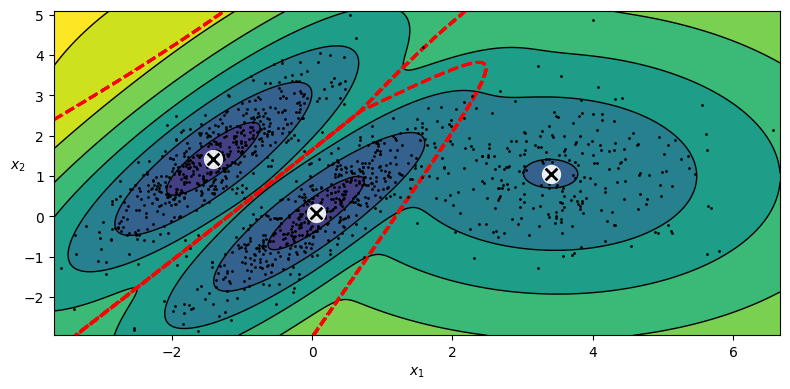

In [119]:
# 추가 코드 - 이 셀은 그림 9-16을 생성하고 저장합니다.

from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

`covariance_type` 하이퍼파라미터를 설정하여 알고리즘이 찾는 공분산 행렬에 제약 조건을 적용할 수 있습니다:
* `"spherical"`: 모든 클러스터는 구형이어야 하지만 직경이 다를 수 있습니다(즉, 분산이 다를 수 있음).
* `"diag"`: 클러스터는 모든 크기의 타원형 모양을 취할 수 있지만 타원의 축은 축과 평행해야 합니다(즉, 공분산 행렬이 대각선이어야 함).
* `"tied"`: 모든 클러스터는 동일한 모양을 가져야 하며, 이는 타원체일 수 있습니다(즉, 모두 동일한 공분산 행렬을 공유해야 함).
* `"full"` (기본값): 제약 없이 모든 클러스터는 모든 크기의 타원형 모양을 취할 수 있습니다.

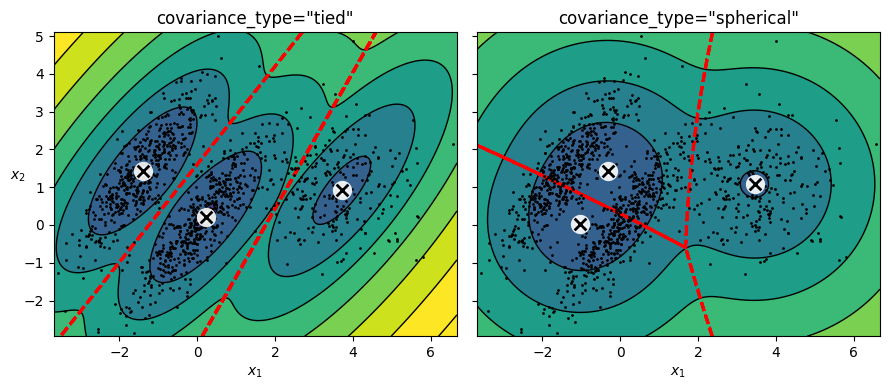

In [120]:
# 추가 코드 - 이 셀은 그림 9-17을 생성하고 저장합니다.

gm_full = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10,
                               covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10,
                          covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')

compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

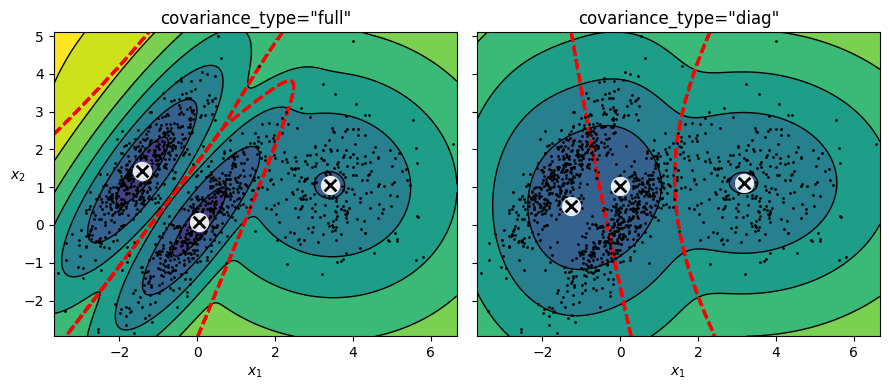

In [121]:
# 추가 코드 - covariance_type="full"과 covariance_type="diag" 비교
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## 9.2.1 가우스 혼합을 사용한 이상치 탐지

가우스 혼합은 _이상치 탐지_에 사용할 수 있습니다: 저밀도 영역에 위치한 샘플을 이상치로 간주할 수 있습니다. 사용하려는 밀도 임계값을 정의해야 합니다. 예를 들어, 결함이 있는 제품을 감지하려는 제조 회사에서는 일반적으로 결함이 있는 제품의 비율을 잘 알고 있습니다. 이 비율이 2%라고 가정하면, 임계값 밀도 아래에 있는 샘플이 2%가 되도록 하는 값으로 밀도 임계값을 설정할 수 있습니다:

In [122]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

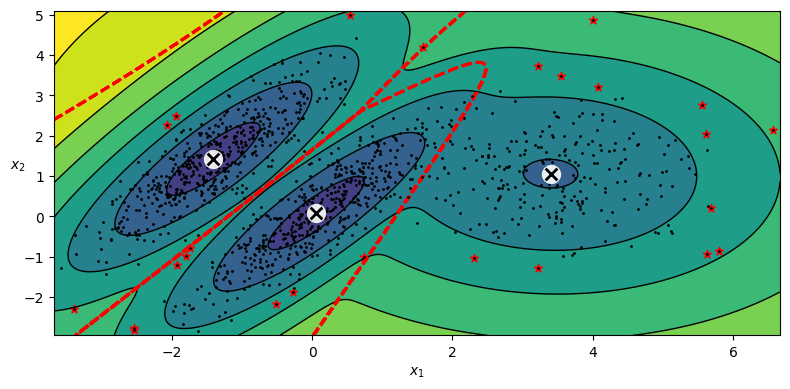

In [123]:
# 추가 코드 - 이 셀은 그림 9-18을 생성하고 저장합니다.

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## 9.2.2 클러스터 수 선택하기

이너셔 또는 실루엣 점수는 모두 클러스터가 구형이라고 가정하기 때문에 사용할 수 없습니다. 대신 BIC 또는 AIC와 같은 이론적 정보 기준을 최소화하는 모델을 찾을 수 있습니다:
${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$은 샘플 수입니다.
* $p$는 모델에서 학습한 파라미터의 수입니다.
* $L$은 모델의 가능도 함수의 최대값입니다. 이것은 모델과 최적화된 파라미터가 주어졌을 때 관찰된 데이터 $\mathbf{X}$의 조건부 확률입니다.

BIC와 AIC는 모두 학습할 파라미터가 많은 모델(예: 더 많은 클러스터)에 불이익을 주고, 데이터에 잘 맞는 모델(예: 관찰된 데이터에 높은 가능성을 부여하는 모델)에 보상을 줍니다.

Font 'default' does not have a glyph for '\ubaa8' [U+baa8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub378' [U+b378], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubaa8' [U+baa8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub378' [U+b378], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubaa8' [U+baa8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub378' [U+b378], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubaa8' [U+baa8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ub378' [U+b378], substituting with a dummy symbol.


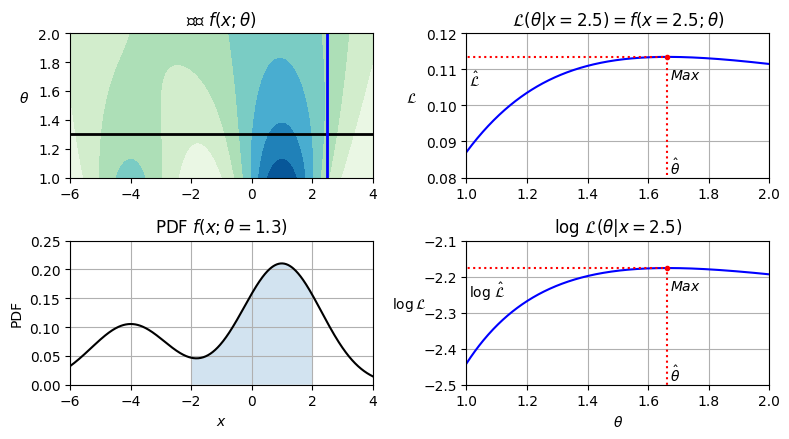

In [124]:
# 추가 코드 - 이 셀은 그림 9-19를 생성하고 저장합니다.

from scipy.stats import norm

x_val = 2.5
std_val = 1.3
x_range = [-6, 4]
x_proba_range = [-2, 2]
stds_range = [1, 2]

xs = np.linspace(x_range[0], x_range[1], 501)
stds = np.linspace(stds_range[0], stds_range[1], 501)
Xs, Stds = np.meshgrid(xs, stds)
Z = 2 * norm.pdf(Xs - 1.0, 0, Stds) + norm.pdf(Xs + 4.0, 0, Stds)
Z = Z / Z.sum(axis=1)[:, np.newaxis] / (xs[1] - xs[0])

x_example_idx = (xs >= x_val).argmax()  # x_val보다 크거나 같은 첫 번째 값의 인덱스
max_idx = Z[:, x_example_idx].argmax()
max_val = Z[:, x_example_idx].max()
s_example_idx = (stds >= std_val).argmax()
x_range_min_idx = (xs >= x_proba_range[0]).argmax()
x_range_max_idx = (xs >= x_proba_range[1]).argmax()
log_max_idx = np.log(Z[:, x_example_idx]).argmax()
log_max_val = np.log(Z[:, x_example_idx]).max()

plt.figure(figsize=(8, 4.5))

plt.subplot(2, 2, 1)
plt.contourf(Xs, Stds, Z, cmap="GnBu")
plt.plot([-6, 4], [std_val, std_val], "k-", linewidth=2)
plt.plot([x_val, x_val], [1, 2], "b-", linewidth=2)
plt.ylabel(r"$\theta$", rotation=0, labelpad=10)
plt.title(r"모델 $f(x; \theta)$")

plt.subplot(2, 2, 2)
plt.plot(stds, Z[:, x_example_idx], "b-")
plt.plot(stds[max_idx], max_val, "r.")
plt.plot([stds[max_idx], stds[max_idx]], [0, max_val], "r:")
plt.plot([0, stds[max_idx]], [max_val, max_val], "r:")
plt.text(stds[max_idx]+ 0.01, 0.081, r"$\hat{\theta}$")
plt.text(stds[max_idx]+ 0.01, max_val - 0.006, r"$Max$")
plt.text(1.01, max_val - 0.008, r"$\hat{\mathcal{L}}$")
plt.ylabel(r"$\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\mathcal{{L}}(\theta|x={x_val}) = f(x={x_val}; \theta)$")
plt.grid()
plt.axis([1, 2, 0.08, 0.12])

plt.subplot(2, 2, 3)
plt.plot(xs, Z[s_example_idx], "k-")
plt.fill_between(xs[x_range_min_idx:x_range_max_idx+1],
                 Z[s_example_idx, x_range_min_idx:x_range_max_idx+1], alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(fr"PDF $f(x; \theta={std_val})$")
plt.grid()
plt.axis([-6, 4, 0, 0.25])

plt.subplot(2, 2, 4)
plt.plot(stds, np.log(Z[:, x_example_idx]), "b-")
plt.plot(stds[log_max_idx], log_max_val, "r.")
plt.plot([stds[log_max_idx], stds[log_max_idx]], [-5, log_max_val], "r:")
plt.plot([0, stds[log_max_idx]], [log_max_val, log_max_val], "r:")
plt.text(stds[log_max_idx]+ 0.01, log_max_val - 0.06, r"$Max$")
plt.text(stds[log_max_idx]+ 0.01, -2.49, r"$\hat{\theta}$")
plt.text(1.01, log_max_val - 0.08, r"$\log \, \hat{\mathcal{L}}$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log\mathcal{L}$", rotation=0, labelpad=10)
plt.title(fr"$\log \, \mathcal{{L}}(\theta|x={x_val})$")
plt.grid()
plt.axis([1, 2, -2.5, -2.1])

save_fig("likelihood_function_plot")
plt.show()

In [125]:
gm.bic(X)

np.float64(8189.733705221636)

In [126]:
gm.aic(X)

np.float64(8102.508425106598)

수동으로 BIC를 계산할 수 있습니다:

In [127]:
# 추가 코드 - 보너스 자료
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood
print(f"bic = {bic}")
print(f"aic = {aic}")
print(f"n_params = {n_params}")

bic = 8189.733705221636
aic = 8102.508425106598
n_params = 17


클러스터당 가중치는 하나이지만 합은 1과 같아야 하므로 자유도가 하나 적고 따라서 1을 뺍니다. 마찬가지로, $n \times n$ 공분산 행렬의 자유도는 $n^2$가 아니라 $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$입니다.

다양한 값의 $k$로 가우시안 혼합 모델을 훈련하고 BIC를 측정해 보겠습니다:

/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:9: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20983/4119370296.py:10: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.savefig(path, format=fig_extension, dpi=resolution)
/

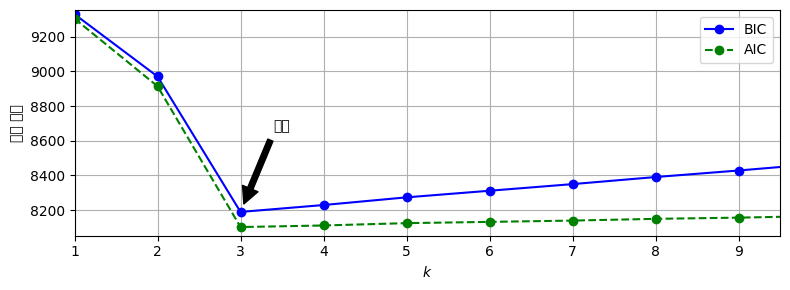

In [128]:
# 추가 코드 - 이 셀은 그림 9-20을 생성하고 저장합니다.

gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("정보 조건")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate("", xy=(3, bics[2]), xytext=(3.4, 8650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.5, 8660, "최소", horizontalalignment="center")
plt.legend()
plt.grid()
save_fig("aic_bic_vs_k_plot")
plt.show()

## 9.2.3 베이즈 가우스 혼합 모델

최적의 클러스터 수를 수동으로 검색하는 대신 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 부여할 수 있는 `BayesianGaussianMixture` 클래스를 사용할 수 있습니다. 성분 개수를 최적의 클러스터 수보다 큰 값으로 설정하기만 하면 알고리즘이 불필요한 클러스터를 자동으로 제거합니다.

In [131]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

알고리즘이 자동으로 3개의 성분만 필요하다는 것을 감지했습니다!

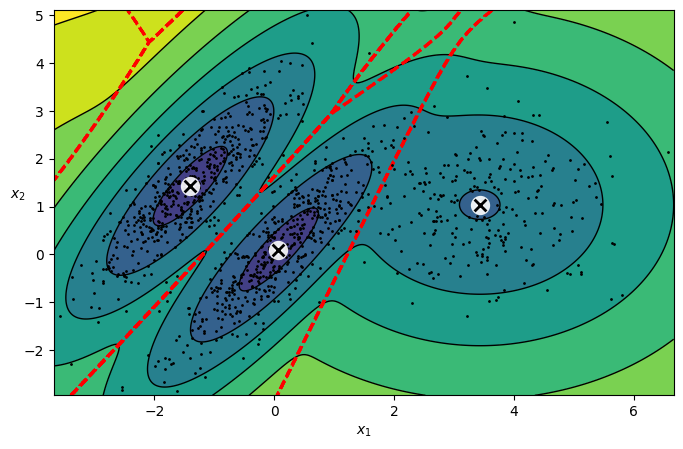

In [132]:
# 추가 코드 - 이 그림은 그림 9-16과 거의 동일합니다.
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

/home/codespace/.local/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


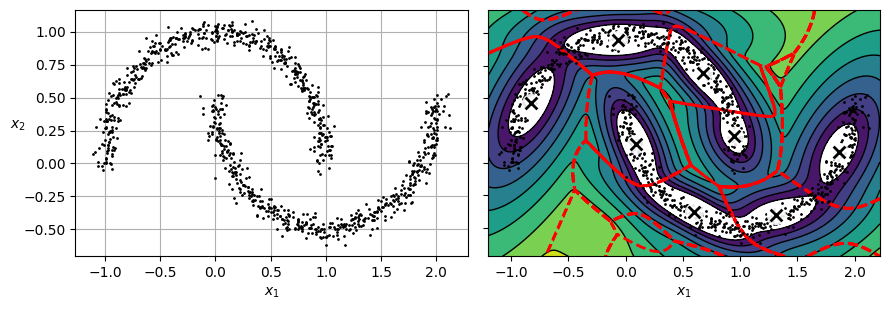

In [133]:
# 추가 코드 - 이 셀은 그림 9-21을 생성하고 저장합니다.

X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.grid()

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

웁스, 좋지 않습니다... 알고리즘이 2개의 달 모양 클러스터를 감지하는 대신 8개의 타원형 클러스터를 감지했습니다. 그러나 밀도 플롯이 너무 나쁘지 않으므로 이상치 탐지에 사용할 수 있습니다.

# 연습문제 해답

## 1. to 9.

부록 A 참조

## 10. 올리베티 얼굴 데이터셋에 군집 적용하기

*문제: 전통적인 올리베티 얼굴 데이터셋은 64×64 픽셀 크기의 흑백 얼굴 이미지 400개를 담고 있습니다. 각 이미지는 4,096 크기의 1D 벡터로 펼쳐져 있습니다. 사람 40명의 사진을 10장씩 찍은 것입니다. 어떤 사람의 사진인지 예측하는 모델을 훈련하는 것이 일반적입니다. `sklearn.datasets.fetch_olivetti_faces()` 함수를 사용해 데이터셋을 불러오세요.*

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [ ]:
print(olivetti.DESCR)

In [ ]:
olivetti.target

*문제:  훈련 세트, 검증 세트, 테스트 세트로 나눕니다(이 데이터셋은 이미 0에서 1 사이로 스케일이 조정되어 있습니다). 이 데이터셋은 매우 작으니 계층적 샘플링을 사용해 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하는 것이 좋습니다.*

In [124]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data,
                                                   olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

작업 속도를 높이기 위해 PCA를 사용하여 데이터의 차원을 줄입니다:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

*문제: 그다음 k-평균을 사용해 이미지를 군집해보세요. (이 장에서 소개한 기법 중 하나를 사용해) 적절한 클러스터 개수를 찾아보세요.*

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print(f"k={k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

In [ ]:
best_k

최고 클러스터 수가 120개로 상당히 많은 것 같습니다. 사진에 40명의 다른 사람이 있기 때문에 40명일 것으로 예상했을 수도 있습니다. 그러나 같은 사람이라도 안경을 착용했거나 착용하지 않았거나 단순히 왼쪽이나 오른쪽으로 이동하는 등 사진에 따라 상당히 다르게 보일 수 있습니다.

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.plot(best_k, best_inertia, "rs")
plt.grid()
plt.show()

이 이너셔 그래프에는 뚜렷한 엘보가 없기 때문에 최적의 클러스터 수가 명확하지 않으므로 k=120을 그대로 사용하겠습니다.

In [131]:
best_model = kmeans_per_k[best_index]

*문제: 클러스터를 시각화해 보세요. 각 클러스터에 비슷한 얼굴이 들어 있나요?*

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

약 2/3 정도의 클러스터가 유용합니다. 즉, 적어도 2개 이상 포함되어 있고 모두 동일한 사람입니다. 그러나 나머지 클러스터에는 다른 사람 얼굴이 하나 이상 있거나 한 장의 사진만 있습니다.

이러한 방식으로 이미지를 클러스터링하는 것은 너무 부정확하여 모델을 훈련할 때 직접적으로 유용하지는 않지만(아래에서 살펴보겠지만), 새 데이터셋에서 이미지에 레이블을 지정할 때 매우 유용할 수 있습니다. 일반적으로 레이블을 훨씬 빠르게 지정할 수 있습니다.

## 11. 분류를 위해 군집으로 전처리하기

*문제: 올리베티 얼굴 데이터셋으로 계속해보겠습니다. 사진에 나타난 사람을 예측하는 분류기를 훈련하고 검증 세트에서 평가해보세요.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

*문제: 그다음 k-평균을 차원 축소 도구로 사용하여 축소된 세트에서 분류기를 훈련해보세요.*

In [ ]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)

clf.score(X_valid_reduced, y_valid)

윽! 전혀 좋아지지 않았군요! 클러스터 개수를 튜닝하면 도움이 되는지 알아 보죠.

*문제: 분류기 성능을 최대로 만드는 클러스터 개수를 찾아보세요. 얼마나 성능이 나오나요?*

앞에서 처럼 `GridSearchCV`를 사용할 수 있습니다. 하지만 검증 세트가 이미 있기 때문에 K-폴드 교차 검증을 할 필요가 없고 하나의 하이퍼파라미터만 탐색하기 때문에 간단히 직접 반복문을 만들겠습니다:

In [ ]:
from sklearn.pipeline import make_pipeline

for n_clusters in k_range:
    pipeline = make_pipeline(
        KMeans(n_clusters=n_clusters, n_init=10, random_state=42),
        RandomForestClassifier(n_estimators=150, random_state=42)
    )
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

클러스터 개수를 튜닝해도 80% 정확도를 넘지 못하는군요. 클러스터 센트로이드까지 거리는 원본 이미지만큼 유용하지 않은 것 같습니다.

*문제: 축소된 세트에서 추출한 특성을 원본 특성에 추가하면 어떤가요? (여기에서도 최선의 클러스터 개수를 찾아보세요.)*

In [136]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [ ]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

조금 나아졌네요. 하지만 클러스터 특성이 없는 것이 차라리 낫습니다. 이 경우 클러스터는 분류기를 직접 훈련하는데 도움이 되지 않습니다(하지만 새로운 훈련 샘플을 레이블링하는데는 여전히 도움이 될 수 있습니다).

## 12. 올리베티 얼굴 데이터셋을 위한 가우시안 혼합 모델

*문제: 올리베티 얼굴 데이터셋에서 가우시안 혼합 모델을 훈련해보세요. 알고리즘의 속도를 높이기 위해 데이터셋의 차원을 감소시켜야 할 것입니다(예를 들면 분산의 99%를 유지하면서 PCA를 사용합니다).*

In [138]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*문제: 이 모델을 사용해 (`sample()` 메서드로) 새로운 얼굴을 생성하고 시각화해보세요(PCA를 사용했다면 `inverse_transform()` 메서드를 사용해야 합니다).*

In [139]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

In [ ]:
plot_faces(gen_faces, y_gen_faces)

*문제: 일부 이미지를 수정해보세요(예를 들면 회전, 뒤집기, 어둡게 하기). 모델이 이상치를 감지하는지 확인해보세요(즉 정상 샘플과 이상치에 대해 `score_samples()` 메서드 출력을 비교해보세요).*

In [ ]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [142]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [ ]:
gm.score_samples(X_bad_faces_pca)

잘못된 사진은 이 가우시안 혼합 모델에서 등장할 가능성이 매우 낮습니다. 다른 훈련 샘플의 점수와 비교해 보세요:

In [ ]:
gm.score_samples(X_train_pca[:10])

## 13. 차원 축소 기법을 사용해 이상치 탐지하기

*문제: 일부 차원 축소 기법은 이상치 탐지를 위해서 사용할 수도 있습니다. 예를 들어 올리베티 얼굴 데이터셋을 PCA를 사용해 분산의 99% 유지하도록 축소해보세요. 그다음 각 이미지의 재구성 오차를 계산합니다. 그다음 이전 연습문제에서 만든 수정된 이미지를 선택해 재구성 오차를 확인해보세요. 재구성 오차가 얼마나 커지는지 확인하세요. 재구성 이미지를 출력해보면 이유를 알 수 있습니다. 정상 얼굴을 재구성하기 때문입니다.*

이미 PCA를 사용해 축소된 데이터셋을 가지고 있습니다:

In [ ]:
X_train_pca.round(2)

In [146]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [ ]:
reconstruction_errors(pca, X_train).mean()

In [ ]:
reconstruction_errors(pca, X_bad_faces).mean()

In [ ]:
plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)